In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
np.random.seed(42)

# Data Preparation

## Define study characteristics and outcome model

In [3]:
N_AB, N_AC = 500, 300
minage_AB, minage_AC = 45, 45
maxage_AB, maxage_AC = 75, 55
femalepc_AB, femalepc_AC = 0.64, 0.8

b_0 = 0.85
b_gender = 0.12
b_age = 0.05
b_age_trt = -0.08
b_trt_B, b_trt_C = -2.1, -2.5

## Generate AB trial data

In [4]:
# generate A arm
AB_IPD = pd.DataFrame.from_dict(
    {
        "id": [p for p in range(int(N_AB / 2))],
        "age": np.random.randint(minage_AB, maxage_AB, int(N_AB / 2)),
        "gender": [
            1 if np.random.random() > femalepc_AB else 0 for _ in range(int(N_AB / 2))
        ],
        "trt": ["A"] * int(N_AB / 2),
    }
)
# generate B arm
AB_IPD = pd.concat(
    [
        AB_IPD,
        pd.DataFrame.from_dict(
            {
                "id": [p + int(N_AB / 2) for p in range(int(N_AB / 2))],
                "age": np.random.randint(minage_AB, maxage_AB, int(N_AB / 2)),
                "gender": [
                    1 if np.random.random() > femalepc_AB else 0
                    for _ in range(int(N_AB / 2))
                ],
                "trt": ["B"] * int(N_AB / 2),
            }
        ),
    ],
    ignore_index=True,
)
# generate outcomes
def yprob(x):
    t = b_0 + b_gender * x["gender"] + b_age * (x["age"] - 40)
    if x["trt"] == "B":
        t += b_trt_B + b_age_trt * (x["age"] - 40)
    elif x["trt"] == "C":
        t += b_trt_C + b_age_trt * (x["age"] - 40)
    return  1 / (1 + np.exp(-t))
AB_IPD["yprob"] = AB_IPD.apply(yprob, axis=1)
AB_IPD["y"] = AB_IPD["yprob"].apply(lambda x: np.random.binomial(1, x))
AB_IPD.drop("yprob", axis=1, inplace=True)

print(AB_IPD.sample(10))
AB_IPD.groupby("trt").agg(
    count=pd.NamedAgg(column="id", aggfunc="count"),
    mean_age=pd.NamedAgg(column="age", aggfunc="mean"),
    sd_age=pd.NamedAgg(column="age", aggfunc="std"),
    n_male=pd.NamedAgg(column="gender", aggfunc="sum"),
    pc_male=pd.NamedAgg(column="gender", aggfunc="mean"),
    sum_y=pd.NamedAgg(column="y", aggfunc="sum"),
    pc_y=pd.NamedAgg(column="y", aggfunc="mean")
)

      id  age  gender trt  y
412  412   45       1   B  0
253  253   73       0   B  0
291  291   69       0   B  0
336  336   73       0   B  0
57    57   51       0   A  1
137  137   52       0   A  1
454  454   56       1   B  0
61    61   62       1   A  0
5      5   52       0   A  1
271  271   61       1   B  0


,count,mean_age,sd_age,n_male,pc_male,sum_y,pc_y
trt,,,,,,,
A,250,60.088,9.236314,89,0.356,213,0.852
B,250,60.240,8.516367,90,0.360,41,0.164


## Generate AC trial data

In [5]:
# generate A arm
AC_IPD = pd.DataFrame.from_dict(
    {
        "id": [p for p in range(int(N_AC / 2))],
        "age": np.random.randint(minage_AC, maxage_AC, int(N_AC / 2)),
        "gender": [
            1 if np.random.random() > femalepc_AC else 0 for _ in range(int(N_AC / 2))
        ],
        "trt": ["A"] * int(N_AC / 2),
    }
)
# generate C arm
AC_IPD = pd.concat(
    [
        AC_IPD,
        pd.DataFrame.from_dict(
            {
                "id": [p for p in range(int(N_AC / 2))],
                "age": np.random.randint(minage_AC, maxage_AC, int(N_AC / 2)),
                "gender": [
                    1 if np.random.random() > femalepc_AC else 0
                    for _ in range(int(N_AC / 2))
                ],
                "trt": ["C"] * int(N_AC / 2),
            }
        ),
    ],
    ignore_index=True,
)
# generate outcomes
AC_IPD["yprob"] = AC_IPD.apply(yprob, axis=1)
AC_IPD["y"] = AC_IPD["yprob"].apply(lambda x: np.random.binomial(1, x))
AC_IPD.drop("yprob", axis=1, inplace=True)

print(AC_IPD.sample(10))
AC_IPD.groupby("trt").agg(
    count=pd.NamedAgg(column="id", aggfunc="count"),
    mean_age=pd.NamedAgg(column="age", aggfunc="mean"),
    sd_age=pd.NamedAgg(column="age", aggfunc="std"),
    n_male=pd.NamedAgg(column="gender", aggfunc="sum"),
    pc_male=pd.NamedAgg(column="gender", aggfunc="mean"),
    sum_y=pd.NamedAgg(column="y", aggfunc="sum"),
    pc_y=pd.NamedAgg(column="y", aggfunc="mean")
)

      id  age  gender trt  y
152    2   49       1   C  0
111  111   48       1   A  1
99    99   54       1   A  0
87    87   47       0   A  1
129  129   46       0   A  1
184   34   49       0   C  0
1      1   47       0   A  1
79    79   47       0   A  1
141  141   47       0   A  1
176   26   45       0   C  0


,count,mean_age,sd_age,n_male,pc_male,sum_y,pc_y
trt,,,,,,,
A,150,49.086667,2.729252,29,0.193333,114,0.760000
C,150,49.426667,2.793441,25,0.166667,17,0.113333


In [6]:
# compute aggregated data for AC trial
AC_AgD = AC_IPD[["age"]].mean()
AC_AgD["age_sd"] = AC_IPD["age"].std()
AC_AgD["n_male"] = AC_IPD["gender"].sum()
AC_AgD["pc_male"] = AC_IPD["gender"].mean()
AC_AgD["y_A_sum"] = AC_IPD.query("trt == 'A'")["y"].sum()
AC_AgD["y_A_mean"] = AC_IPD.query("trt == 'A'")["y"].mean()
AC_AgD["n_A"] = AC_IPD.query("trt == 'A'")["id"].count()
AC_AgD["y_C_sum"] = AC_IPD.query("trt == 'C'")["y"].sum()
AC_AgD["y_C_mean"] = AC_IPD.query("trt == 'C'")["y"].mean()
AC_AgD["n_C"] = AC_IPD.query("trt == 'C'")["id"].count()

AC_AgD

age          49.256667
age_sd        2.762165
n_male       54.000000
pc_male       0.180000
y_A_sum     114.000000
y_A_mean      0.760000
n_A         150.000000
y_C_sum      17.000000
y_C_mean      0.113333
n_C         150.000000
dtype: float64

# MAIC

In [7]:
def objfn(a1, X):
    return np.sum(np.exp(np.matmul(X, a1)))

def gradfn(a1, X):
    return np.dot(np.exp(np.matmul(X, a1)), X)

X_EM_0 = AB_IPD[["age"]].copy()
X_EM_0["age2"] = X_EM_0["age"] ** 2
X_EM_0["age"] = X_EM_0["age"] - AC_AgD["age"]
X_EM_0["age2"] = X_EM_0["age2"] - (AC_AgD["age"] ** 2 + AC_AgD["age_sd"] ** 2)

In [8]:
# https://machinelearningmastery.com/bfgs-optimization-in-python/
from scipy.optimize import minimize

result = minimize(objfn, (0, 0), method="BFGS", jac=gradfn, args=(X_EM_0))
result

      fun: 171.9138549068442
 hess_inv: array([[ 5.74253115e-01, -5.73046222e-03],
       [-5.73046222e-03,  5.72601343e-05]])
      jac: array([-5.49654295e-08, -4.76872356e-06])
  message: 'Optimization terminated successfully.'
     nfev: 25
      nit: 18
     njev: 25
   status: 0
  success: True
        x: array([ 3.77172597, -0.03925683])

count    5.000000e+02
mean     1.000000e+00
std      1.492560e+00
min      1.344335e-11
25%      1.343886e-07
50%      1.513295e-02
75%      2.246636e+00
max      4.158954e+00
dtype: float64


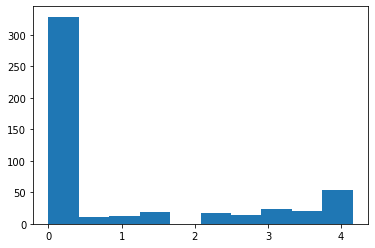

In [9]:
a1 = result.x
wt = np.exp(np.matmul(X_EM_0, a1))
wt_rs = wt / np.sum(wt) * N_AB
print(wt_rs.describe())
plt.hist(wt_rs);

In [10]:
ESS = np.sum(wt) ** 2 / sum(wt)
ESS

171.91385490684428

In [11]:
AB_IPD["weight"] = wt
AB_IPD["age"] * AB_IPD["weight"]

0      5.169562e+01
1      4.152280e-03
2      2.490797e-09
3      7.549372e-01
4      1.173865e+01
           ...     
495    1.566350e-05
496    3.420425e-10
497    4.214765e-02
498    1.043071e-07
499    3.485204e+00
Length: 500, dtype: float64

In [12]:
age_mean = (AB_IPD["age"] * wt_rs).mean()
age_sd = np.sqrt(np.sum((wt / np.sum(wt)) * (AB_IPD["age"] - age_mean) ** 2))
age_mean, age_sd

(49.25666666634694, 2.7621647439784947)

In [13]:
list(AC_AgD[["age", "age_sd"]].values)

[49.25666666666667, 2.762164743298141]